Homework for Session #1 of the Creative Applications of Deep Learning (CADL) course
offered by Kadenze.
Following instructions at https://github.com/pkmital/CADL/blob/master/session-1/session-1.ipynb

In [25]:
import numpy as np
import tensorflow as tf
import os
import matplotlib.pyplot as plt
from libs import utils

In [26]:
# 100 images from the Caltech 101 watch dataset from
# http://www.vision.caltech.edu/Image_Datasets/Caltech101/
dirname = '/home/harini/cadl/notebooks/data/watch'

In [27]:
# preprocess the images - crop to square, resize to 100x100.
imgs = utils.preprocess_images(dirname)
data = np.array(imgs)
print(len(imgs))
print(imgs[0].shape)
print(data.shape)

/home/harini/cadl/lib/python3.6/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


100
(100, 100, 3)
(100, 100, 100, 3)


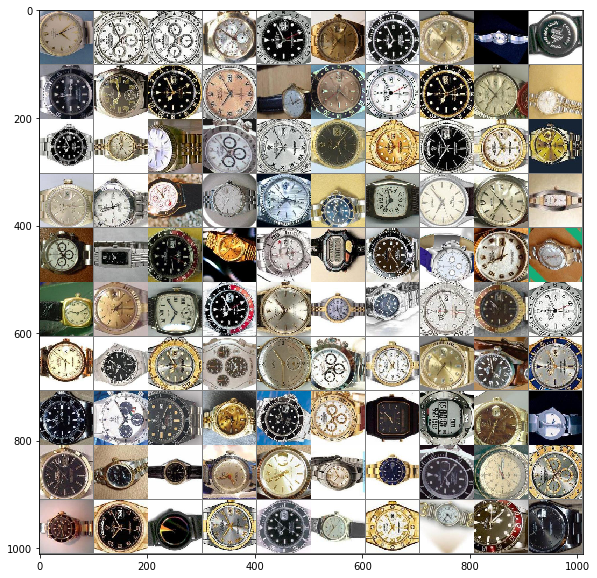

In [28]:
# display a montage of the images in the dataset.
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(data, saveto='dataset.png'))

In [29]:
# create a tensorflow session
sess = tf.InteractiveSession()

/home/harini/cadl/lib/python3.6/site-packages/tensorflow/python/client/session.py:1711: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [30]:
# calculate the mean of the images in the dataset and display
mean_image_op = tf.reduce_mean(data, axis=0)
mean_img = mean_image_op.eval()
print(mean_img.shape)

(100, 100, 3)


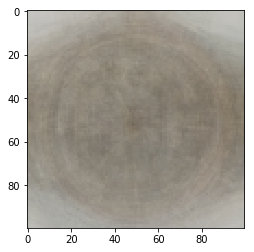

In [31]:
plt.imshow(mean_img)
plt.imsave(arr=mean_img, fname='mean.png')

In [32]:
# calculate the std deviation of the images in the dataset.
# tf doesn't have an operation like np.std, so calculate stddev as the sqrt of variance
# (which is sq(data - mean))
# keepdims is added to the reduce_mean to make the dims of mean 4d (i.e. same as data).
diff = data - tf.reduce_mean(data, axis=0, keepdims=True)
stddev = tf.sqrt(tf.reduce_mean(diff * diff, axis=0))
std_img = stddev.eval()
print(std_img.shape)

(100, 100, 3)


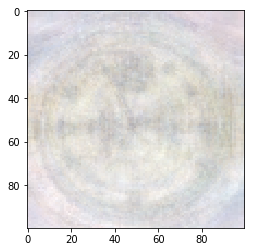

In [33]:
std_img_show = std_img / np.max(std_img)
plt.imshow(std_img_show)
plt.imsave(arr=std_img_show, fname="std.png")

In [34]:
# normalize the images i.e. (data - mean)/stddev
norm_op = tf.convert_to_tensor((data - mean_img)/std_img)
norm_imgs = norm_op.eval()
print(norm_imgs.shape)
print(np.min(norm_imgs), np.max(norm_imgs))

(100, 100, 100, 3)
-2.7263332755021015 2.5550535626437774


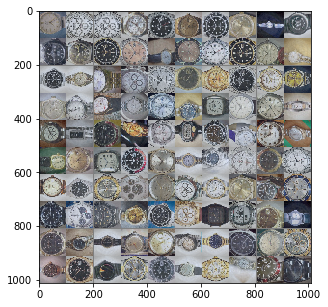

In [35]:
# do another normalization to keep the range between 0 and 1 so that display is nicer.
norm_imgs_show = (norm_imgs - np.min(norm_imgs)) / (np.max(norm_imgs) - np.min(norm_imgs))
plt.figure(figsize=(5, 5))
plt.imshow(utils.montage(norm_imgs_show))

In [36]:
# create a gabor kernel for edge detection
kersize=20
gabor = utils.gabor_2d(0.0, 1.0, kersize).eval()
print(gabor.shape)
# create a kernel for each channel
kernel = np.concatenate([gabor[:, :, np.newaxis] for i in range(3)], axis=2)
# reshape to kh x kw x c x o
kernel_4d = tf.reshape(kernel, (kersize, kersize, 3, 1)).eval()
print(kernel_4d.shape)

(20, 20)
(20, 20, 3, 1)


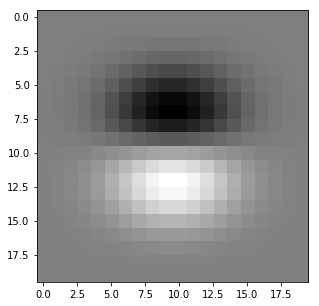

In [37]:
plt.figure(figsize=(5, 5))
plt.imshow(kernel_4d[:, :, 0, 0], cmap='gray')

In [38]:
# perform the convolution
conv_op = tf.nn.conv2d(data, kernel_4d, strides=[1, 1, 1, 1], padding='SAME')
conv_img = conv_op.eval()
print(conv_img.shape)

(100, 100, 100, 1)


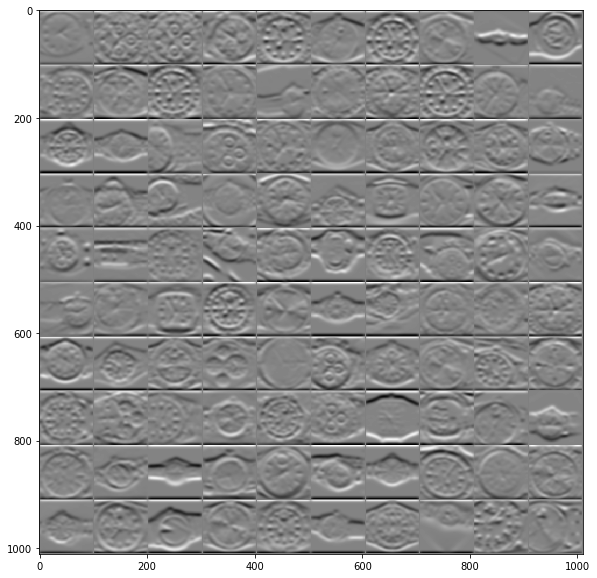

In [39]:
# normalize convolved image and display
conv_show = (conv_img - np.min(conv_img)) / (np.max(conv_img) - np.min(conv_img))
plt.figure(figsize=(10,10))
plt.imshow(utils.montage(conv_show[..., 0]), cmap='gray')

In [40]:
# flatten each convolved image to a vector to prepare for sorting.
# i.e. shape (N, H, W, C) now becomes (N, (HxWxC))
flattened = tf.reshape(conv_img, 
                       (conv_img.shape[0], 
                        (conv_img.shape[1] * conv_img.shape[2] * conv_img.shape[3])))
print(flattened.shape)

(100, 10000)


In [41]:
# sum the flattened values, sort, and display original images in sorted order 
# of the convolved result.
vals = tf.reduce_sum(flattened, axis=1)
sort_op = tf.nn.top_k(vals, k=100)[1]
idxs = sort_op.eval()
sorted_img = np.array([data[idx] for idx in idxs])
print(sorted_img.shape)

(100, 100, 100, 3)


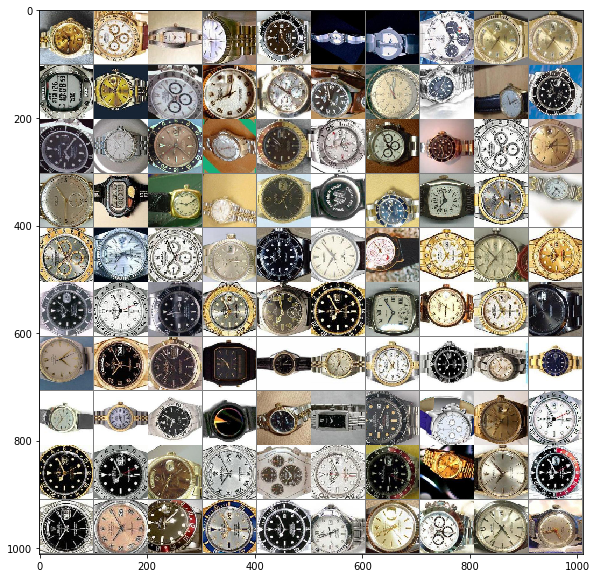

In [42]:
plt.figure(figsize=(10, 10))
plt.imshow(utils.montage(sorted_img), cmap='gray')